# CNN1 SETTINGS

SUBJECT'S DATA SELECTION:                                                                                                  
- **A**: Signal samples: 7794, EEG channels: 64, Testset letters: 100                                                           
- **B**: Signal samples: 7794, EEG channels: 64, Testset letters: 100 

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np                
from scipy.io import loadmat
from scipy import signal
import warnings
import string
import os

from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale
import mne


warnings.filterwarnings('ignore')

import keras
import tensorflow as tf
print(keras.__version__)
print(tf.__version__)



####################### SETTINGS ########################
# Set this variable with the desidered subject's letter #
SUBJECT_SELECTED = "II"                                 #
#########################################################

subject_names = ["I", "II"]



# Google drive data paths
MODEL_LOCATIONS_FILE_PATH = '../model/CNN1/' + SUBJECT_SELECTED
SUBJECT_TRAIN_FILE_PATH = '../data/Contributor_' + SUBJECT_SELECTED + '_Train.mat'
SUBJECT_TEST_FILE_PATH = '../data/Contributor_' + SUBJECT_SELECTED + '_Test.mat'
CHANNEL_LOCATIONS_FILE_PATH = '../data/channels.csv'
CHANNEL_COORD = '../data/coordinates.csv'

# Channel selection
CHANNELS = [i for i in range(64)]

# pip install scipy==1.1.0
# pip install keras==2.2.4
# pip install mne==0.17
# pip install scikit-learn==0.20.0

3.7.0
2.18.0


# Training set processing

1.   Application of bandpass filter **(0.1-20Hz)**;
2.   Down-sampling signals from 240Hz to 120Hz;
3.   Obtain windows of 650ms at the start of every flashing (175ms)
4.   Normalization of samples in each window: **Zi = (Xi - mu) / sigma**;
5.   Reshape each window to be a 3D tensor with dimensions: **(N_SAMPLES, 78, 64)**;
6.   Obtain **(noP300 / P300)** class ratio to balance out dataset during training;

In [109]:
if not os.path.exists(SUBJECT_TRAIN_FILE_PATH):
    print("Missing file: {}".format(SUBJECT_TRAIN_FILE_PATH))
else:
    # Load the required data
    data = loadmat(SUBJECT_TRAIN_FILE_PATH)
    # Get the variables of interest from the loaded dictionary
    signals = data['Signal']
    flashing = data['Flashing']
    stimulus = data['StimulusType']
    word = data['TargetChar']
    
    SAMPLING_FREQUENCY = 240
    # From the dataset description we know that there are 15 repetitions
    REPETITIONS = 15
    # Compute the duration of the recording in minutes
    RECORDING_DURATION = (len(signals))*(len(signals[0]))/(SAMPLING_FREQUENCY*60)
    # Compute number of trials
    TRIALS = len(word[0])
    # Set flag to True to balance the training set
    BALANCE_DATASET = False

    print("**********************************")
    print("       TRAIN SET INFORMATION      ")
    print("**********************************")
    print("Sampling Frequency: %d Hz [%.2f ms]" % (SAMPLING_FREQUENCY, (1000/SAMPLING_FREQUENCY)))
    print("Session duration:   %.2f min" % RECORDING_DURATION)
    print("Number of letters:  %d" % TRIALS)
    print("Spelled word:       %s" % ''.join(word))

**********************************
       TRAIN SET INFORMATION      
**********************************
Sampling Frequency: 240 Hz [4.17 ms]
Session duration:   46.01 min
Number of letters:  85
Spelled word:       VGREAAH8TVRHBYN_UGCOLO4EUERDOOHCIFOMDNU6LQCPKEIREKOYRQIDJXPBKOJDWZEUEWWFOEBHXTQTTZUMO


In [110]:
# Application of butterworth filter
b, a = signal.butter(4, [0.1/SAMPLING_FREQUENCY, 20/SAMPLING_FREQUENCY], 'bandpass')
for trial in range(TRIALS):
    signals[trial, :, :] = signal.filtfilt(b, a, signals[trial, :, :], axis=0)

In [111]:
# Down-sampling of the signals from 240Hz to 120Hz
DOWNSAMPLING_FREQUENCY = 120
SCALE_FACTOR = round(SAMPLING_FREQUENCY / DOWNSAMPLING_FREQUENCY)
SAMPLING_FREQUENCY = DOWNSAMPLING_FREQUENCY

print("# Samples of EEG signals before downsampling: {}".format(len(signals[0])))

signals = signals[:, 0:-1:SCALE_FACTOR, :]
flashing = flashing[:, 0:-1:SCALE_FACTOR]
stimulus = stimulus[:, 0:-1:SCALE_FACTOR]

print("# Samples of EEG signals after downsampling: {}".format(len(signals[0])))

# Samples of EEG signals before downsampling: 7794
# Samples of EEG signals after downsampling: 3897


In [112]:
# Number of EEG channels
N_CHANNELS = len(CHANNELS)
# Window duration after each flashing [ms]
WINDOW_DURATION = 650
# Number of samples of each window
WINDOW_SAMPLES = round(SAMPLING_FREQUENCY * (WINDOW_DURATION / 1000))
# Number of samples for each character in trials
SAMPLES_PER_TRIAL = len(signals[0])

train_features = []
train_labels = []

count_positive = 0
count_negative = 0

for trial in range(TRIALS):
    for sample in (range(SAMPLES_PER_TRIAL)):
        if (sample == 0) or (flashing[trial, sample-1] == 0 and flashing[trial, sample] == 1):
            lower_sample = sample
            upper_sample = sample + WINDOW_SAMPLES
            window = signals[trial, lower_sample:upper_sample, :]                
            # Features extraction
            train_features.append(window)
            # Labels extraction
            if stimulus[trial, sample] == 1:
                count_positive += 1
                train_labels.append(1) # Class P300
            else:
                count_negative += 1
                train_labels.append(0) # Class no-P300

# Get negative-positive classes ratio
train_ratio = count_negative/count_positive

# Convert lists to numpy arrays
train_features = np.array(train_features)
train_labels = np.array(train_labels)

# 3D Tensor shape (SAMPLES, 64, 78)
dim_train = train_features.shape
print("Features tensor shape: {}".format(dim_train))

Features tensor shape: (15300, 78, 64)


In [113]:
# Data normalization Zi = (Xi - mu) / sigma
for pattern in range(len(train_features)):
    train_features[pattern] = scale(train_features[pattern], axis=0)

# Testing set processing

1.   Application of bandpass filter **(0.1-20Hz)**;
2.   Down-sampling signas from 240Hz to 120Hz;
3.   Obtain windows of 650ms at the start of every flashing (175ms)
4.   Normalization of samples in each window: **Zi = (Xi - mu) / sigma**;
5.   Reshape each window to be a 3D tensor with dimensions: **(N_SAMPLES, 78, 64)**;
6.   Calculate weights vector to balance samples importance and obtain correct accuracy estimation;

In [114]:
# Test data loading
if not os.path.exists(SUBJECT_TEST_FILE_PATH):
    print("Missing file: {}", SUBJECT_TEST_FILE_PATH)
else:
    # Load the required data
    data_test = loadmat(SUBJECT_TEST_FILE_PATH)
    # Get the variables of interest from the loaded dictionary
    signals_test = data_test['Signal']
    flashing_test = data_test['Flashing']
    word_test =  data_test['TargetChar']
    stimulus_code_test = data_test['StimulusCode']

    SAMPLING_FREQUENCY = 240
    # From the dataset description we know that there are 15 repetitions
    REPETITIONS = 15
    # Compute the duration of the recording in minutes
    RECORDING_DURATION_TEST = (len(signals_test))*(len(signals_test[0]))/(SAMPLING_FREQUENCY*60)
    # Compute number of trials
    TRIALS_TEST = len(word_test[0])
    # Number of samples for each character in trials
    SAMPLES_PER_TRIAL_TEST = len(signals_test[0])
    
    print("**********************************")
    print("        TEST SET INFORMATION      ")
    print("**********************************")
    print("Sampling Frequency: %d Hz [%.2f ms]" % (SAMPLING_FREQUENCY, (1000/SAMPLING_FREQUENCY)))
    print("Session duration:   %.2f min" % RECORDING_DURATION_TEST)
    print("Number of letters:  %d" % TRIALS_TEST)
    print("Spelled word:       %s" % ''.join(word_test))

**********************************
        TEST SET INFORMATION      
**********************************
Sampling Frequency: 240 Hz [4.17 ms]
Session duration:   54.12 min
Number of letters:  100
Spelled word:       MERMIROOMUHJPXJOHUVLEORZP3GLOO7AUFDKEFTWEOOALZOP9ROCGZET1Y19EWX65QUYU7NAK_4YCJDVDNGQXODBEV2B5EFDIDNR


In [115]:
# Create characters matrix
char_matrix = [[0 for j in range(6)] for i in range(6)]
s = string.ascii_uppercase + '1' + '2' + '3' + '4' + '5' + '6' + '7' + '8' + '9' + '_'

# Append cols and rows in a list
list_matrix = []
for i in range(6):
    col = [s[j] for j in range(i, 36, 6)]
    list_matrix.append(col)
for i in range(6):
    row = [s[j] for j in range(i * 6, i * 6 + 6)]
    list_matrix.append(row)

# Create StimulusType array for the test set (missing from the given database)
stimulus_test = [[0 for j in range(SAMPLES_PER_TRIAL_TEST)] for i in range(TRIALS_TEST)]
stimulus_test = np.array(stimulus_test)

for trial in range(TRIALS_TEST):
    counter=0
    for sample in range(SAMPLES_PER_TRIAL_TEST):
        index = int(stimulus_code_test[trial, sample]) - 1
        if not index == -1:
            if word_test[0][trial] in list_matrix[index]:
                stimulus_test[trial, sample] = 1
            else:
                stimulus_test[trial, sample] = 0

In [116]:
# Application of butterworth filter
b, a = signal.butter(4, [0.1/SAMPLING_FREQUENCY, 20/SAMPLING_FREQUENCY], 'bandpass')
for trial in range(TRIALS_TEST):
    signals_test[trial, :, :] = signal.filtfilt(b, a, signals_test[trial, :, :], axis=0)

In [117]:
# Down-sampling of the signals from 240Hz to 120Hz
DOWNSAMPLING_FREQUENCY = 120
SCALE_FACTOR = round(SAMPLING_FREQUENCY / DOWNSAMPLING_FREQUENCY)
SAMPLING_FREQUENCY = DOWNSAMPLING_FREQUENCY

print("# Samples of EEG signals before downsampling: {}".format(len(signals_test[0])))

signals_test = signals_test[:, 0:-1:SCALE_FACTOR, :]
flashing_test = flashing_test[:, 0:-1:SCALE_FACTOR]
stimulus_test = stimulus_test[:, 0:-1:SCALE_FACTOR]

print("# Samples of EEG signals after downsampling: {}".format(len(signals_test[0])))

# Samples of EEG signals before downsampling: 7794
# Samples of EEG signals after downsampling: 3897


In [118]:
# Number of EEG channels
N_CHANNELS = len(CHANNELS)
# Window duration after each flashing [ms]
WINDOW_DURATION = 650
# Number of samples of each window
WINDOW_SAMPLES = round(SAMPLING_FREQUENCY * (WINDOW_DURATION / 1000))
# Number of samples for each character in trials
SAMPLES_PER_TRIAL_TEST = len(signals[0])

test_features = []
test_labels = []
windowed_stimulus = []

count_positive = 0
count_negative = 0

for trial in range(TRIALS_TEST):
    for sample in (range(SAMPLES_PER_TRIAL_TEST)):
        if (sample == 0) or (flashing_test[trial, sample-1] == 0 and flashing_test[trial, sample] == 1):
            lower_sample = sample
            upper_sample = sample + WINDOW_SAMPLES
            window = signals_test[trial, lower_sample:upper_sample, :]
            # Extracting number of row/col in a window
            number_stimulus = int(stimulus_code_test[trial, sample])
            windowed_stimulus.append(number_stimulus)
            # Features extraction
            test_features.append(window)
            # Labels extraction
            if stimulus_test[trial, sample] == 1:
                count_positive += 1
                test_labels.append(1) # Class P300
            else:
                count_negative += 1
                test_labels.append(0) # Class no-P300

# Get test weights to take into account the number of classes 
test_weights = []
for i in range(len(test_labels)):
    if test_labels[i] == 1:
        test_weights.append(len(test_labels)/count_positive)
    else:
        test_weights.append(len(test_labels)/count_negative)
test_weights = np.array(test_weights)

# Convert lists to numpy arrays
test_features = np.array(test_features)
test_labels = np.array(test_labels)

# 3D tensor (SAMPLES, 64, 78)
dim_test = test_features.shape
print("Features tensor shape: {}".format(dim_test))

Features tensor shape: (18000, 78, 64)


In [119]:
# Data normalization Zi = (Xi - mu) / sigma
for pattern in range(len(test_features)):
    test_features[pattern] = scale(test_features[pattern], axis=0)

# CNN1 model definition, training and testing

1.   Function definiton for randomization of weights and biases;
2.   **Scaled_tanh(x)** activation function definition;
3.   ANN model definition (2 Conv1D layers, 2 dense layers);
4.   Training of the network over weighted dataset;
5.   CNN1 performance assessment;

In [120]:

# Randomizing function for bias and weights of the network
def cecotti_normal(shape, dtype=None):
    if len(shape) == 1:
        fan_in = shape[0]
    elif len(shape) == 2:
        fan_in = shape[0]
    else:
        receptive_field_size = 1
        for dim in shape[:-2]:
            receptive_field_size *= dim
        fan_in = shape[-2] * receptive_field_size
    stddev = 1.0 / fan_in
    return K.random_normal(shape, mean=0.0, stddev=stddev, dtype=dtype)

# Custom tanh activation function
def scaled_tanh(z):
    return 1.7159 * K.tanh((2.0 / 3.0) * z)

# Build the model
def CNN1_model(channels=64, filters=10):
    model = Sequential([
        Conv1D(
            filters=filters,
            kernel_size=1,
            padding="same",
            bias_initializer=cecotti_normal,
            kernel_initializer=cecotti_normal,
            use_bias=True,
            activation=lambda x: scaled_tanh(x),
            input_shape=(78, channels)
        ),
        Conv1D(
            filters=50,
            kernel_size=13,
            padding="valid",
            strides=11,
            bias_initializer=cecotti_normal,
            kernel_initializer=cecotti_normal,
            use_bias=True,
            activation=lambda x: scaled_tanh(x),
        ),
        Flatten(),
        Dense(100, activation="sigmoid"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
    return model

# Training parameters
BATCH_SIZE = 256
EPOCHS = 50
VALID_SPLIT = 0.05
SHUFFLE = 1  # set to 1 to shuffle subsets during training

# Model summary
model = CNN1_model(channels=64, filters=10)
model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_16 (Conv1D)              │ (None, 78, 10)         │           650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 6, 50)          │         6,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 300)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,401 (146.10 KB)

 Trainable params: 37,401 (146.10 KB)

 Non-trainable params: 0 (0.00 B)

In [121]:
import numpy as np

# Define model
model = CNN1_model(channels=64, filters=10)

# Callback to stop when loss on validation set doesn't decrease in 50 epochs
earlystop = EarlyStopping(monitor='val_loss', 
                          mode='min', 
                          patience=50, 
                          restore_best_weights=True)

# Train the model and store history
history = model.fit(x=train_features, 
                    y=train_labels, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    validation_split=VALID_SPLIT, 
                    callbacks=[earlystop],
                    shuffle=SHUFFLE,
                    class_weight={0: 1., 1: train_ratio})

# Find the epoch with the lowest validation loss
best_epoch = np.argmin(history.history['val_loss'])
print(f"Best epoch: {best_epoch + 1} with validation loss: {history.history['val_loss'][best_epoch]}")

# Reload the best weights manually
best_weights = model.get_weights()
model.set_weights(best_weights)

# Define a new model to reuse the best configuration
best_model = CNN1_model(channels=64, filters=10)
best_model.set_weights(best_weights)

# Compile the best model
best_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5718 - loss: 0.4045 - val_accuracy: 0.6745 - val_loss: 0.2075
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7092 - loss: 0.3236 - val_accuracy: 0.7869 - val_loss: 0.1598
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7453 - loss: 0.2926 - val_accuracy: 0.7673 - val_loss: 0.1602
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7603 - loss: 0.2774 - val_accuracy: 0.7425 - val_loss: 0.1699
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7662 - loss: 0.2734 - val_accuracy: 0.7556 - val_loss: 0.1638
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7633 - loss: 0.2685 - val_accuracy: 0.8183 - val_loss: 0.1307
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7797 - loss: 0.2651 - val_accuracy: 0.7765 - val_loss: 0.1548
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7671 - loss: 0.2700 - val_accuracy: 0.8039 - val_loss

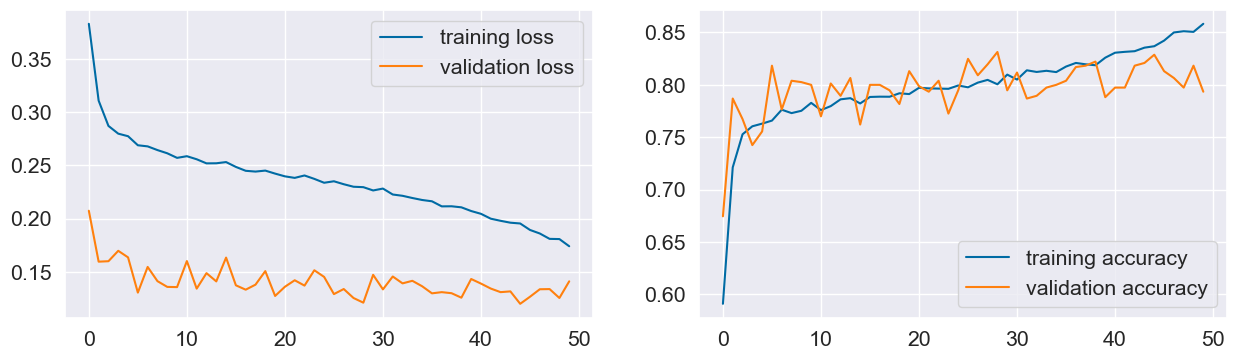

In [122]:
plt.figure(figsize=(15,4))
plt.style.use('tableau-colorblind10')

# Plots of loss curves during training
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label="training loss")
plt.plot(history.history['val_loss'], label="validation loss")
plt.legend()

# Plots of accuracy curves during training
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label="training accuracy")
plt.plot(history.history['val_accuracy'], label="validation accuracy")
plt.legend()

plt.show()

['Fc5', 'Fc3', 'Fc1', 'Fcz', 'Fc2', 'Fc4', 'Fc6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'Cp5', 'Cp3', 'Cp1', 'Cpz', 'Cp2', 'Cp4', 'Cp6', 'Fp1', 'Fpz', 'Fp2', 'Af7', 'Af3', 'Afz', 'Af4', 'Af8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'Ft7', 'Ft8', 'T7', 'T8', 'T9', 'T10', 'Tp7', 'Tp8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'Po7', 'Po3', 'Poz', 'Po4', 'Po8', 'O1', 'Oz', 'O2', 'Iz']
[0, 1, 2, 3, 4, 5, 6, 14, 15, 16, 17, 18, 19, 20, 24, 25, 26, 27, 28, 38, 39, 44, 45, 55, 56, 57, 58, 59]
['C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'Fp1', 'Fpz', 'Fp2', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'T7', 'T8', 'T9', 'T10', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'O1', 'Oz', 'O2', 'Iz']


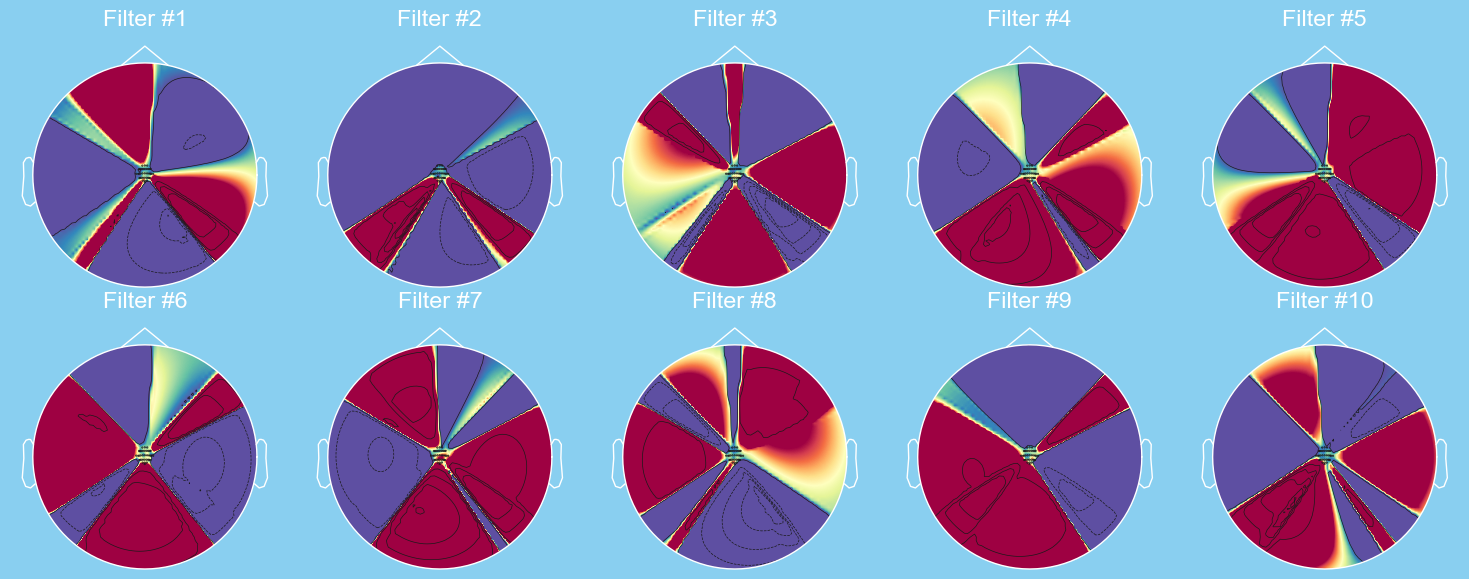

In [132]:
import numpy as np
import matplotlib.pyplot as plt
import mne

# Example EEG channel names and a standard montage
channel_names = [
    "Fp1", "Fp2", "F7", "F3", "Fz", "F4", "F8",
    "T7", "C3", "Cz", "C4", "T8", "P7", "P3", "Pz",
    "P4", "P8", "O1", "Oz", "O2"
]


import csv

# Read CSV file into a Python list
electrode_names = []

with open(CHANNEL_LOCATIONS_FILE_PATH, "r") as file:
    csv_reader = csv.reader(file)
    for row in csv_reader:
        electrode_names.extend(row)  # Add each row to the list (handles single-column CSV)

print(electrode_names)


electrode_names_to_remove = ['Fc5', 'Fc3', 'Fc1', 'Fcz', 'Fc2', 'Fc4', 'Fc6', 'Cp5', 'Cp3', 'Cp1', 'Cpz', 'Cp2', 'Cp4', 'Cp6', 'Af7', 'Af3', 'Afz', 'Af4', 'Af8', 'Ft7', 'Ft8', 'Tp7', 'Tp8', 'Po7', 'Po3', 'Poz', 'Po4', 'Po8']
# remove this channel from the list



# Create array has the original index for electrode_names_to_remove in electrode_names
index = []
for i in range(len(electrode_names_to_remove)):
    index.append(electrode_names.index(electrode_names_to_remove[i]))
print(index)

electrode_names = [x for x in electrode_names if x not in electrode_names_to_remove]
print(electrode_names)
    
    
montage = mne.channels.make_standard_montage("standard_1020")

# Create random weights for 10 filters (20 channels)
n_channels = len(electrode_names)
n_filters = 10

# Create a list of weights for all filters
nf = []
for filt in range(10):
    nf.append(abs(np.array(best_model.get_weights()[0])[0, :, filt]))
# remove the channels from the weights 
nf = np.delete(nf, index, axis=1)



# Create an Info object with EEG channel names
info = mne.create_info(ch_names=electrode_names, sfreq=1000, ch_types="eeg")
info.set_montage(montage)

# Plot topomap for each filter
# Set give me array of background color
fig, axes = plt.subplots(2, 5, figsize=(15, 6), facecolor="#89CFF0")  # Set overall background to black
axes = axes.flatten()

for i in range(n_filters):
    ax = axes[i]
    ax.set_facecolor("black")  # Set individual subplot background to black
    mne.viz.plot_topomap(
        nf[i], info, axes=ax, cmap="Spectral_r", sphere=1.2, show=False  # Adjust `sphere` to scale brain size
    )
    ax.set_title(f"Filter #{i + 1}", color="white")  # Set title color to white for better visibility

plt.tight_layout()
plt.show()


In [124]:
# Accuracy over the testing set
predictions = best_model.predict(test_features)
predictions = np.round(predictions)

score = np.array(best_model.evaluate(test_features, test_labels, verbose=0, sample_weight=test_weights))
print("Model performance on test set:\t[ Loss: {}\tAccuracy: {} ]".format(*score.round(4)))
print("\nPredictions: {}\nSolutions:   {}".format(list(map(int, predictions))[:50], list(map(int, test_labels))[:50]))

563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model performance on test set:	[ Loss: 0.3729	Accuracy: 0.7998 ]

Predictions: [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1]
Solutions:   [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1]


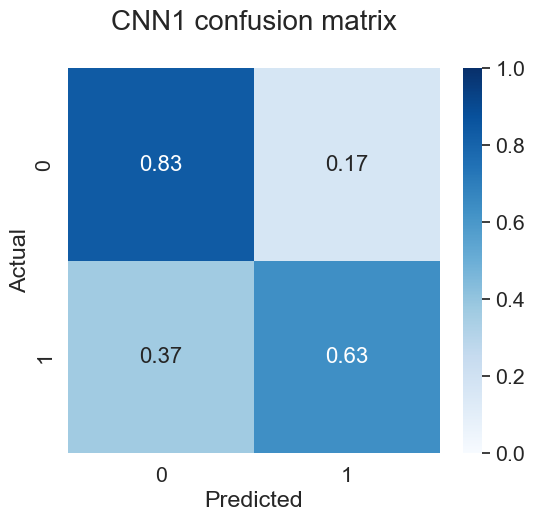

In [125]:
# Weighted confusion matrix (noP300: 80%, P300: 20%)
data = confusion_matrix(y_true=test_labels, y_pred=predictions, sample_weight=test_weights)

# Normalized confusion matrix (values in range 0-1)
data_norm = data/np.full(data.shape, len(test_labels))

# Plot the confusion matrix
df_cm = pd.DataFrame(data_norm, columns=np.unique(test_labels), index = np.unique(test_labels))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (6,5))
sns.set(font_scale = 1.4)
cm = sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws = {"size": 16}, vmin=0, vmax=1)
cm.axes.set_title("CNN1 confusion matrix\n", fontsize=20)
plt.show()

In [126]:
# Model metrics (sens, spec, ppv, npv)
def model_metrics(conf_matrix):
    tn, fp, fn, tp = list(data_norm.flatten())
    sens = round(tp/(tp+fn),4) # Sensitivity
    spec = round(tn/(tn+fp),4) # Specificity
    ppv = round(tp/(tp+fp),4) # Positive Predicted Value
    npv = round(tn/(tn+fn),4) # Negative Predicted Value
    return {"Sensitivity":sens, "Specificity":spec, "PPV":ppv, "NPV":npv}

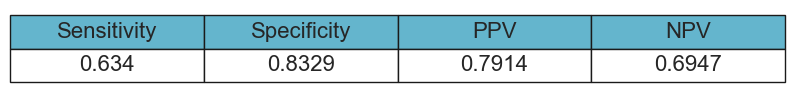

In [127]:
# Put model metrics into a table
metrics = model_metrics(data_norm)

# Create figure
fig = plt.figure(figsize=(5,1))
ax = fig.add_subplot(111)

# Hide graph outlines
for item in [fig, ax]:
    item.patch.set_visible(False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)

# Table definition
table = ax.table(cellText=[list(metrics.values())], 
                     colLabels=list(metrics.keys()),
                     loc="center",
                     cellLoc="center",
                     colColours=["c"]*4)
table.set_fontsize(16)
table.scale(2,2)

plt.show()